<a href="https://colab.research.google.com/github/kssmp/Text_classification_LTSM/blob/main/text_classification_wineries_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['description', 'points'] , error_bad_lines = False , engine = "python")
df.head()

<ipython-input-9-1c2ccd03ff3a>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("wine-reviews.csv", usecols = ['description', 'points'] , error_bad_lines = False , engine = "python")


,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [ ]:
df.dropna()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87
...,...,...
95314,This delicious and spicy dessert wine from Mon...,91
95315,"Here's an inviting Chianti Classico riserva, w...",91
95316,This amber-colored nectar is a quintessential ...,91
95317,Here's a stunning sparkling wine made in the c...,91


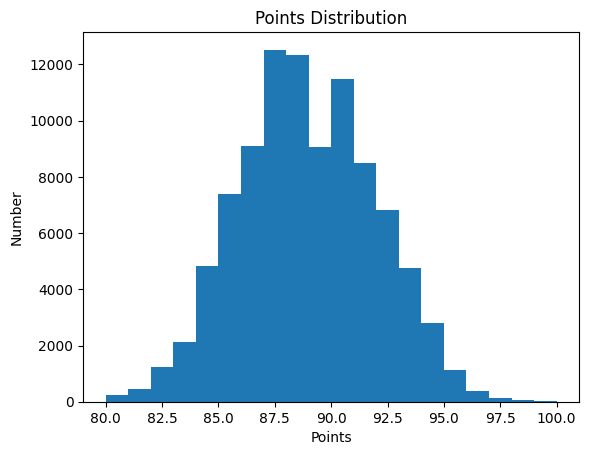

In [ ]:
plt.hist(df.points , bins = 20)
plt.title("Points Distribution")
plt.xlabel("Points")
plt.ylabel("Number")
plt.show()

In [ ]:
df["label"] = (df.points >=90).astype(int) # converting out points into 1s and 0s
df.head()

,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


In [ ]:
train , valid , test = np.split(df.sample(frac = 1) , [int(0.8*len(df)) , int(0.9*len(df))]) # splits as 80% ->train | 10% ->validation | 10% ->test


In [ ]:
# this function will basically prep our df for us
def df_to_dataset (dataframe , shuffle = True , batch_size = 1024):
  df = dataframe.copy()
  labels = df.pop('label') # drops label from df and labels has only the outputs now
  df = df['description'] # now only as the text reviews left
  ds = tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds = ds.shuffle(buffer_size = len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE) # this makes sure that the next batch of data is ready beforehand
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

# Embedding for conversion of text to computer friendly format & ML Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2" # basically tensorflow hub gives us access to pretrained model which we can use for purposes like embedding our text inputs for the model
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 4.21432823e-01, -1.83661193e-01,  2.00721007e-02, ...,
        -1.97613612e-01, -1.79063126e-01,  2.58407950e-01],
       [ 3.72837812e-01,  1.57685041e-01,  2.66864300e-01, ...,
        -2.49557123e-01, -1.88754573e-01,  1.42894655e-01],
       [ 3.56305361e-01, -1.61055356e-01,  2.09918514e-01, ...,
        -2.71528196e-02, -5.32899916e-01, -6.05432950e-02],
       ...,
       [ 3.22047919e-01, -3.72218224e-03,  1.04582630e-01, ...,
         2.09979955e-02, -1.96475014e-01,  3.13875228e-02],
       [ 1.45688400e-01,  1.44519634e-03,  3.78027596e-02, ...,
        -2.88412482e-01, -8.27469081e-02,  6.17945741e-04],
       [ 3.27087998e-01, -1.05306193e-01, -8.94205049e-02, ...,
         6.73625544e-02, -4.53008562e-02,  1.05960644e-04]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16 , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16 , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1 , activation = 'sigmoid'))

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_data , epochs = 5 ,  validation_data = valid_data)

Epoch 1/5
75/75 [==============================] - 117s 2s/step - loss: 0.6466 - accuracy: 0.6081 - val_loss: 0.5646 - val_accuracy: 0.6706
Epoch 2/5
75/75 [==============================] - 104s 1s/step - loss: 0.5334 - accuracy: 0.7178 - val_loss: 0.4438 - val_accuracy: 0.8034
Epoch 3/5
75/75 [==============================] - 100s 1s/step - loss: 0.4441 - accuracy: 0.8046 - val_loss: 0.3998 - val_accuracy: 0.8158
Epoch 4/5
75/75 [==============================] - 99s 1s/step - loss: 0.3937 - accuracy: 0.8359 - val_loss: 0.3903 - val_accuracy: 0.8151
Epoch 5/5
75/75 [==============================] - 99s 1s/step - loss: 0.3625 - accuracy: 0.8527 - val_loss: 0.3859 - val_accuracy: 0.8236


In [ ]:
model.evaluate(test_data)

10/10 [==============================] - 2s 202ms/step - loss: 0.3921 - accuracy: 0.8242


[0.3920697867870331, 0.8241711854934692]

##LTSM - long short term memory
Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network can process not only single data points, but also entire sequences of data. 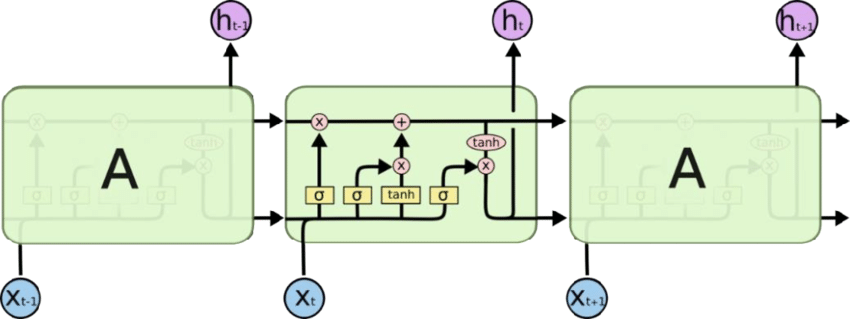

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens = 2000) # maxtokens is the maximum vocabulary size -> encoder will only consider the 2000 most frequent words in the training data
encoder.adapt(train_data.map(lambda text , label : text)) #->builds the vocabulary based on the frequency of the tokens in the training data

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32 , activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1 , activation = 'sigmoid')
])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
              )

In [ ]:
history = model.fit(train_data , epochs = 5 , validation_data = valid_data)

Epoch 1/5
75/75 [==============================] - 50s 525ms/step - loss: 0.5901 - accuracy: 0.6770 - val_loss: 0.4242 - val_accuracy: 0.8086
Epoch 2/5
75/75 [==============================] - 40s 536ms/step - loss: 0.3972 - accuracy: 0.8238 - val_loss: 0.3611 - val_accuracy: 0.8385
Epoch 3/5
75/75 [==============================] - 41s 545ms/step - loss: 0.3635 - accuracy: 0.8397 - val_loss: 0.3546 - val_accuracy: 0.8417
Epoch 4/5
75/75 [==============================] - 42s 554ms/step - loss: 0.3479 - accuracy: 0.8475 - val_loss: 0.3533 - val_accuracy: 0.8376
Epoch 5/5
75/75 [==============================] - 41s 542ms/step - loss: 0.3391 - accuracy: 0.8522 - val_loss: 0.3546 - val_accuracy: 0.8391


In [ ]:
model.evaluate(test_data)

10/10 [==============================] - 4s 397ms/step - loss: 0.3582 - accuracy: 0.8381


[0.35816052556037903, 0.8381242156028748]